In [1]:
!pip install keras-tuner

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, GRU, TimeDistributed, RepeatVector
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import pickle
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## Load data

In [3]:
data_train = pd.read_csv('/kaggle/input/dataset/data_train.csv')
data_val = pd.read_csv('/kaggle/input/dataset/data_val.csv')
data_test = pd.read_csv('/kaggle/input/dataset/data_test.csv')

In [4]:
data_train.head()

,appearance,delivery,fabric_quality,others,packaging,price,service,size_fit,processed_text
0,0,0,0,0,0,0,0,1,áo nhỏ hơn so với mô_tả
1,3,0,0,0,0,0,0,0,áo đẹp như mẫu luôn nha mọi người
2,0,3,0,2,0,0,0,0,rất hài_lòng sản_phẩm tốt shop giao đúng mẫu n...
3,0,0,0,0,0,0,0,3,nâng ngực ôm gọn bầu ngực mặc ok lắm
4,3,0,3,0,0,0,0,0,quần đẹp vải mát cho kiểm hàng kĩ rất hài_lòng...


In [5]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(0, len(df.columns)-1):
            sentiment = df.iloc[row, col]
            if   sentiment == 0: one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1: one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2: one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 0, 1] # Neu
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')

In [6]:
label_train = make_outputs(data_train)
label_val = make_outputs(data_val)
label_test = make_outputs(data_test)

print('Train outputs:', label_train.shape)
print('Validate outputs:', label_val.shape)
print('Test outputs:', label_test.shape)

Train outputs: (3631, 8, 4)
Validate outputs: (454, 8, 4)
Test outputs: (454, 8, 4)


## Load embedding data

In [7]:
embeddings = {}
for state in ['train', 'val', 'test']:
    embeddings[state] = np.load(f'/kaggle/input/embeddings/embeddings_{state}_PhoBert.npy', allow_pickle=True)
    embeddings[state] = np.vstack(embeddings[state])

In [8]:
print('Train inputs:', embeddings['train'].shape)
print('Validate inputs:', embeddings['val'].shape)
print('Test intputs:', embeddings['test'].shape)

Train inputs: (3631, 768)
Validate inputs: (454, 768)
Test intputs: (454, 768)


In [9]:
list_aspect = data_train.columns[:-1]
len(list_aspect)

8

## Bidirectional GRU and conv1D model

In [10]:
embedding_dim = 768
num_aspects = 8
output_dim = 4

In [11]:
def bigru_conv(hp):    
    # Hyperparameters to tune
    units = hp.Choice('units', [100, 200, 300])
    learning_rate = hp.Choice('learning_rate', [0.0001, 0.0002, 0.0005])
    dropout_rate = hp.Choice('dropout_rate', [0.1, 0.2, 0.3])
    
    # Define input layer
    input_layer = Input(shape=(embedding_dim,))

    # Expand dimensions to match the input shape requirement of the GRU
    input_expanded = RepeatVector(num_aspects)(input_layer)

    # Define Bidirectional GRU layer
    lstm_layer = Bidirectional(GRU(units=units, activation='tanh', return_sequences=True))(input_expanded)

    # Adding a Conv1D layer after GRU
    conv_layer = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(lstm_layer)

    # TimeDistributed layer to apply Dense layers across all time steps
    aspect_dense2 = TimeDistributed(Dense(128, activation='relu'))(conv_layer)
    aspect_dropout1 = TimeDistributed(Dropout(dropout_rate))(aspect_dense2)
    aspect_dense3 = TimeDistributed(Dense(64, activation='relu'))(aspect_dropout1)
    aspect_dense4 = TimeDistributed(Dense(32, activation='relu'))(aspect_dense3)

    # Output layer: num_aspects * output_dim units corresponding to 8 aspects with 4 categories each
    aspect_dense5 = TimeDistributed(Dense(units=4, activation='softmax'))(aspect_dense4)

    # Define and compile the model
    aspect_model = tf.keras.Model(inputs=input_layer, outputs=aspect_dense5)
    aspect_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return aspect_model

## Hypeparameter tuning

In [12]:
tuner = kt.RandomSearch(
    bigru_conv,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='/kaggle/working',
    project_name='ASBA_model'
)

padded_aspect_train = embeddings['train']
padded_aspect_val = embeddings['val']
label_aspect_train = label_train
label_aspect_val = label_val
                                      
tuner.search(padded_aspect_train, label_aspect_train, 
             validation_data=(padded_aspect_val, label_aspect_val), 
             epochs=100, 
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Trial 10 Complete [00h 00m 28s]
val_loss: 0.2777378559112549

Best val_loss So Far: 0.2718938887119293
Total elapsed time: 00h 05m 23s


In [13]:
model_gru_conv = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", best_hyperparameters.values)

Best Hyperparameters: {'units': 300, 'learning_rate': 0.0001, 'dropout_rate': 0.3}


In [14]:
model_gru_conv.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 8, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 8, 600)         │     1,926,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 64)          │       115,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 128)         │         8,320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 8, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 8, 64)          │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 8, 32)          │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 8, 4)           │           132 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,060,052 (7.86 MB)

 Trainable params: 2,060,052 (7.86 MB)

 Non-trainable params: 0 (0.00 B)

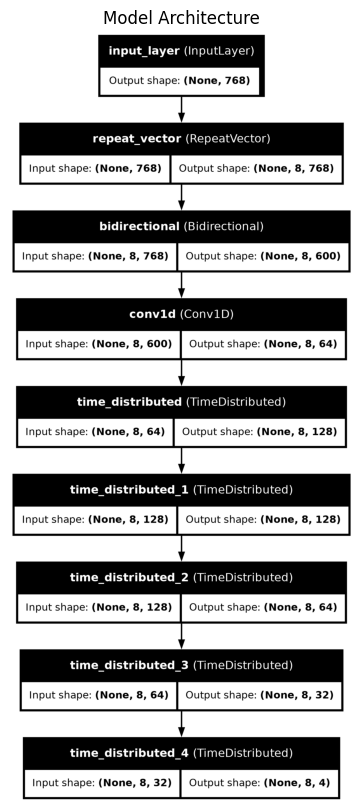

In [15]:
# Model architecture
plot_model(model_gru_conv, to_file='/kaggle/working/model_architecture.png', show_shapes=True, show_layer_names=True)

img = plt.imread('/kaggle/working/model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title('Model Architecture')
plt.axis('off')
plt.show()

In [16]:
# save model
model_gru_conv.save('/kaggle/working/best_model.h5')

## Result and evaluation

In [17]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    return np.argmax(y_pred, axis=-1)
def print_acsa_pred(replacements, categories, sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments):
        if sentiment: print(f'=> {category}: {sentiment}')

In [18]:
predictions = model_gru_conv.predict(embeddings['test'])

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(label_test, axis=-1)

# Evaluate the model and store the results in a DataFrame
output_GRU_conv = pd.DataFrame()
for i in range(num_aspects):
    aspect_name = data_train.columns[i]
    print(f"{aspect_name}:")
    report = classification_report(true_labels[:, i], predicted_labels[:, i], labels=[0, 1, 2, 3], target_names=['None', 'Negative', 'Neutral', 'Positive'], output_dict=True, zero_division=0)

    # Create a DataFrame from the report
    aspect_report_df = pd.DataFrame(report).transpose()
    aspect_report_df['Aspect'] = aspect_name  # Add a column for the aspect name

    # Append the report for this aspect to the main DataFrame
    output_GRU_conv = pd.concat([output_GRU_conv, aspect_report_df], ignore_index=False)

    # If you want to print the classification report as well
    print(aspect_report_df.round(2))
    print('-'*80)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
appearance:
              precision  recall  f1-score  support      Aspect
None               0.88    0.84      0.86   271.00  appearance
Negative           0.41    0.53      0.46    17.00  appearance
Neutral            0.00    0.00      0.00     8.00  appearance
Positive           0.79    0.87      0.83   158.00  appearance
accuracy           0.82    0.82      0.82     0.82  appearance
macro avg          0.52    0.56      0.54   454.00  appearance
weighted avg       0.81    0.82      0.82   454.00  appearance
--------------------------------------------------------------------------------
delivery:
              precision  recall  f1-score  support    Aspect
None               1.00    0.98      0.99    393.0  delivery
Negative           1.00    0.33      0.50      3.0  delivery
Neutral            0.00    0.00      0.00      0.0  delivery
Positive           0.84    0.98      0.90     58.0  delivery
micro avg          0.97    0.97      0.97    454

In [19]:
y_pred_gru_conv = predict(model_gru_conv, embeddings['test'], verbose=1)
model_gru_conv.evaluate(embeddings['test'], label_test, verbose=1)

454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9140 - loss: 0.2425


[0.25365355610847473, 0.9113436341285706]

In [20]:
replacements = {0: None, 3: 'positive', 1: 'negative', 2: 'neutral'}
categories = data_test.columns[:-1]
print('Example:', data_test['processed_text'][11])
print_acsa_pred(replacements,categories, y_pred_gru_conv[11])

Example: màu_sắc tươi_tắn gia_công rất tốt mặc thoải_mái
=> fabric_quality: positive


In [21]:
aspect_test = []
aspect_pred = []
y_test_argmax = np.argmax(label_test, axis=-1)

for row_test, row_pred in zip(y_test_argmax, y_pred_gru_conv):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])

In [22]:
aspect_report = classification_report(aspect_test, aspect_pred, digits=2, zero_division=1, output_dict=True)

# Convert the dictionary to a pandas DataFrame
aspect_report_df = pd.DataFrame(aspect_report).transpose()
aspect_report_df

,precision,recall,f1-score,support
,0.947649,0.954332,0.950979,2978.000000
appearance,0.775510,0.830601,0.802111,183.000000
delivery,0.869565,0.983607,0.923077,61.000000
fabric_quality,0.808743,0.826816,0.817680,179.000000
others,0.742268,0.742268,0.742268,97.000000
packaging,0.705882,0.666667,0.685714,18.000000
price,0.888889,0.421053,0.571429,38.000000
service,0.571429,0.235294,0.333333,17.000000
size_fit,0.717391,0.540984,0.616822,61.000000
accuracy,0.919328,0.919328,0.919328,0.919328


In [23]:
f1_scores_list = []
overall_sentiment_f1 = 0

for i in range(num_aspects):
    aspect_name = data_train.columns[i]

    # Aspect Detection F1
    aspect_detection_f1 = aspect_report_df['f1-score'][aspect_name]

    # Sentiment Analysis F1
    report = classification_report(true_labels[:, i], predicted_labels[:, i], labels=[0, 1, 2, 3],
                                   target_names=['None', 'Negative', 'Neutral', 'Positive'],
                                   output_dict=True, zero_division=0)
    sentiment_f1 = report['weighted avg']['f1-score']
    overall_sentiment_f1 += sentiment_f1

    f1_scores_list.append({
        'Aspect': aspect_name,
        'Aspect Detection (F1 Score)': aspect_detection_f1,
        'Sentiment Analysis (F1 Score)': sentiment_f1
    })

# Calculate overall scores
macro_aspect_detection_f1 = aspect_report_df['f1-score']['macro avg']
average_sentiment_f1 = overall_sentiment_f1 / num_aspects

f1_scores_list.append({
    'Aspect': 'overall',
    'Aspect Detection (F1 Score)': macro_aspect_detection_f1,
    'Sentiment Analysis (F1 Score)': average_sentiment_f1
})

f1_scores_df = pd.DataFrame(f1_scores_list)
f1_scores_df.round(2)

,Aspect,Aspect Detection (F1 Score),Sentiment Analysis (F1 Score)
0,appearance,0.80,0.82
1,delivery,0.92,0.97
2,fabric_quality,0.82,0.82
3,others,0.74,0.89
4,packaging,0.69,0.98
5,price,0.57,0.94
6,service,0.33,0.96
7,size_fit,0.62,0.88
8,overall,0.72,0.91
